# Assigning the lpGBTs to the Slinks

Main boundary conditions:
- Done per 120-degree sector.
- Each 120-degree sector has 28 FPGAs.
- Each FPGA has either:
  - 12× 16G Slink outputs => 336 Slink outputs, or
  - 8× 25G Slink outputs => 224 Slink outputs.

One idea:
- Straddling ECONDs imply that an lpGBT pair is the quantum of the system.
- Single lpGBTs need to be paired:
  - Sort their rates and then take largest and smallest in pairs.
- Pairs of lpGBTs are then assigned to individual Slinks:
  - Max of 8 lpGBT pairs per Slink.


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 144

In [2]:
linkRates = pd.read_hdf('out/merged.h5', 'linkRates')

In [3]:
linkRates

,DAQlpGBT,EvSize,Elinks,Layer,U,V,LUV,nModules,doubleDAQlpGBT,EvSize [kb],BitsPerElink
0,12,240.4057,7.0,1,4.666667,1.333333,332.0,3,False,7.692982,1098.997486
1,13,240.2424,7.0,1,3.333333,4.666667,314.0,3,False,7.687757,1098.250971
2,14,142.4875,5.0,1,6.500000,0.000000,360.0,4,False,4.559600,911.920000
3,15,142.2112,5.0,1,6.500000,6.500000,366.5,4,False,4.550758,910.151680
4,16,176.1495,6.0,1,7.000000,6.000000,374.0,5,False,5.636784,939.464000
...,...,...,...,...,...,...,...,...,...,...,...
105,894,157.3610,8.0,29,2.333333,3.666667,7465.0,3,True,5.035552,629.444000
106,907,186.1277,8.0,30,4.000000,2.000000,7746.0,3,True,5.956086,744.510800
107,920,170.0694,9.0,30,1.000000,4.000000,7700.0,3,True,5.442221,604.691200
108,922,169.7657,9.0,30,3.000000,4.000000,7732.0,3,True,5.432502,603.611378


In [4]:
n_doubles = len(linkRates[ linkRates.doubleDAQlpGBT ])
n_singles = len(linkRates[ ~linkRates.doubleDAQlpGBT ])
n_links = n_singles + 2*n_doubles
print(f"""
There is a total of {n_links} lpGBT links:
 - {n_singles} singles, and
 - {n_doubles} doubles (with one ECOND straddling the pair)
""")


There is a total of 1508 lpGBT links:
 - 1288 singles, and
 - 110 doubles (with one ECOND straddling the pair)



In [5]:
sortedRates = linkRates[ ~linkRates.doubleDAQlpGBT ].sort_values(by='EvSize')

In [6]:
#SizeSortedRates =  linkRates
SizeSortedRates =  linkRates.sort_values(by='EvSize', ascending=True)
SizeSortedRates

,DAQlpGBT,EvSize,Elinks,Layer,U,V,LUV,nModules,doubleDAQlpGBT,EvSize [kb],BitsPerElink
1158,1378,12.1890,5.0,40,15.0,2.0,10482.0,1,False,0.390048,78.009600
1160,1380,12.1951,5.0,40,15.0,4.0,10484.0,1,False,0.390243,78.048640
1162,1382,12.1958,5.0,40,15.0,6.0,10486.0,1,False,0.390266,78.053120
1159,1379,12.1976,5.0,40,15.0,3.0,10483.0,1,False,0.390323,78.064640
1164,1384,12.1992,5.0,40,15.0,8.0,10488.0,1,False,0.390374,78.074880
...,...,...,...,...,...,...,...,...,...,...,...
40,192,461.9141,13.0,7,3.0,0.0,1840.0,3,True,14.781251,1137.019323
13,62,467.5174,13.0,3,3.0,3.0,819.0,3,True,14.960557,1150.812062
12,60,467.6358,13.0,3,3.0,0.0,816.0,3,True,14.964346,1151.103508
24,124,483.2248,13.0,5,3.0,0.0,1328.0,3,True,15.463194,1189.476431


In [7]:
assert( len(sortedRates)%2 == 0 )

Since there are singles with larger rates than some doubles, the naive pairing of singles need not be a good idea.

In [8]:
linkRates['nDAQlpGBT'] = linkRates.doubleDAQlpGBT.apply(lambda d: 2 if d else 1)

# A playground for optimization functions

This problem cannot be solved with linear-programming techniques.

Since the assignment of a lpGBT to a Slink is a boolean variable, we're in the domain of [mixed-integer non-linear programming (MINLP)](https://www.google.com/search?q=python+MINLP).

I found two python libraries that model such problems: `GEKKO` and `pyomo`.

Some other resources:
- http://plato.asu.edu/sub/tools.html
- https://www.zanaducloud.com/7935420D-38BB-47B4-AD1C-ADEF76CA6884
- https://www.localsolver.com/download.html

## Setting up the toy problem

In [9]:
nGBTSingles = 132
#nGBTSingles = len(SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== False) ])
nGBTDoubles = 12
#nGBTDoubles = len(SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== True) ])
maxSlinkRate = 300
nSlinks = 24 #336
nFPGA = 2 #28

#---------------------------------------------------

nGBTs = nGBTSingles + nGBTDoubles
maxGBTsPerSlink = 12
SlinkPerFPGA = 12

In [10]:
print(f"""
Toy problem parameters:
- {nGBTs} lpGBT inputs.
  - {nGBTSingles} lpGBT singles, and
  - {nGBTDoubles} lpGBT doubles.
- {nSlinks} Slink outputs.
  - Up to {maxGBTsPerSlink} lpGBTs served by each SLink.
-{maxSlinkRate} limit on Slink rates.
""")
print(f"""
 - {nFPGA} FPGAs and
 - {SlinkPerFPGA} Slinks served by each FPGA.
""")


Toy problem parameters:
- 144 lpGBT inputs.
  - 132 lpGBT singles, and
  - 12 lpGBT doubles.
- 24 Slink outputs.
  - Up to 12 lpGBTs served by each SLink.
-300 limit on Slink rates.


 - 2 FPGAs and
 - 12 Slinks served by each FPGA.



In [11]:
mode='HtoL' #{'HtoL': high to low, 'LtoH': low to high, 'Ht': highest, 'Lt': lowest}

lowS=SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== False) ]["EvSize"][:int(nGBTSingles/3)].to_dict()
medS=SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== False) ]["EvSize"][int(len(SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== False) ])/2)-int(nGBTSingles/6):int(len(SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== False) ])/2)+int(nGBTSingles/6)].to_dict()
highS=SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== False) ]["EvSize"][-1*int(nGBTSingles/3):].to_dict()
lowD=SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== True) ]["EvSize"][:int(nGBTDoubles/3)].to_dict()
medD=SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== True) ]["EvSize"][int(len(SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== True) ])/2)-int(nGBTDoubles/6):int(len(SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== True) ])/2)+int(nGBTDoubles/6)].to_dict()
highD=SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== True) ]["EvSize"][-1*int(nGBTDoubles/3):].to_dict()

if mode=='LtoH':
    medS.update(highS)
    lowS.update(medS)
    medD.update(highD)
    lowD.update(medD)
    singleGBTRates = lowS
    doubleGBTRates = lowD
if mode=='HtoL':
    medS.update(lowS)
    highS.update(medS)
    medD.update(lowD)
    highD.update(medD)
    singleGBTRates = highS
    doubleGBTRates = highD
if mode=='Lt':
    SizeSortedRates =  linkRates.sort_values(by='EvSize', ascending=True)
    singleGBTRates = SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== False) ]["EvSize"][:nGBTSingles].to_dict()
    doubleGBTRates = SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== True)  ]["EvSize"][:nGBTDoubles].to_dict()
if mode=='Ht':
    SizeSortedRates =  linkRates.sort_values(by='EvSize', ascending=False)
    singleGBTRates = SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== False) ]["EvSize"][:nGBTSingles].to_dict()
    doubleGBTRates = SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== True)  ]["EvSize"][:nGBTDoubles].to_dict()

#print(len(singleGBTRates))
#print(singleGBTRates)
#print(len(doubleGBTRates))
#print(doubleGBTRates)

In [12]:
totalRate = ( sum([i for i in singleGBTRates.values()])+sum([i for i in doubleGBTRates.values()]) )

In [13]:
print(f"""
Total lpGBT rate: {totalRate}
Average lpGBT rate: {totalRate /nGBTs}
Average Slink rate: {totalRate / nSlinks}
""")


Total lpGBT rate: 17717.175629999994
Average lpGBT rate: 123.03594187499996
Average Slink rate: 738.2156512499997



In [14]:
maxSlinkRatePyomo = (totalRate / nSlinks)*1.4
maxSlinkRateGekko = (totalRate / nSlinks)*1.4
print("maxSlinkRatePyomo: ",maxSlinkRatePyomo)
print("maxSlinkRateGekko: ",maxSlinkRateGekko)

maxSlinkRatePyomo:  1033.5019117499996
maxSlinkRateGekko:  1033.5019117499996


## Pyomo Start

Pyomo solver options are set in the file "../apopt-master/apopt.py".

In [15]:
import numpy as np
import pyomo
import pyomo.environ as pyo
print(pyomo.__version__)
from pyomo.gdp import *
from pyomo.environ import value

5.7.1


In [16]:
model = pyo.ConcreteModel()

In [17]:
Single=[str(k) for k in singleGBTRates.keys()]
Double = [str(k) for k in doubleGBTRates.keys()]
Slink = [str(i) for i in range(1,nSlinks+1)]
FPGA = [str(i) for i in range(1,nFPGA+1)]
print(Single)
print(Double)
print(Slink)
print(FPGA)

['58', '382', '40', '380', '570', '568', '112', '474', '114', '472', '506', '504', '290', '292', '410', '408', '219', '218', '316', '201', '318', '200', '36', '38', '442', '440', '76', '78', '346', '344', '238', '236', '378', '376', '264', '262', '165', '164', '183', '182', '1', '0', '19', '18', '792', '35', '34', '739', '723', '722', '233', '657', '658', '776', '659', '656', '777', '232', '753', '395', '1010', '1011', '1073', '394', '1067', '615', '690', '614', '1108', '633', '635', '307', '331', '634', '632', '702', '1093', '1043', '301', '306', '300', '329', '330', '328', '764', '1088', '1025', '585', '1158', '1160', '1162', '1159', '1164', '1166', '1167', '1157', '1165', '1161', '1156', '1163', '1146', '1149', '1148', '1147', '1145', '1150', '1152', '1151', '1153', '1155', '1154', '1144', '1134', '1137', '1142', '1133', '1136', '1139', '1135', '1143', '1138', '1132', '1140', '1141', '1130', '1127', '1126', '1121', '1131', '1123', '1124', '1122']
['13', '12', '24', '25', '1', '62', 

In [18]:
#model.GKSingles = pyo.Var(Single, Slink, initialize=np.random.choice([0, 1], p=[1-1/nSlinks, 1/nSlinks]), within = pyo.NonNegativeIntegers, bounds=(0, 1))
#model.GKDoubles = pyo.Var(Double, Slink, initialize=np.random.choice([0, 1], p=[1-1/nSlinks, 1/nSlinks]), within = pyo.NonNegativeIntegers, bounds=(0, 1))
#model.GKSlinks = pyo.Var(Slink, FPGA, initialize=np.random.choice([0, 1], p=[1-1/nSlinks, 1/nSlinks]), within = pyo.NonNegativeIntegers, bounds=(0, 1))

model.GKSingles = pyo.Var(Single, Slink, initialize = 0, within = pyo.Binary)
model.GKDoubles = pyo.Var(Double, Slink, initialize = 0, within = pyo.Binary)
model.GKSlinks = pyo.Var(Slink, FPGA, initialize = 0, within = pyo.Binary)

In [19]:
def SetNumberofLinks1(model, i):
    return sum([ model.GKSingles[i, j] for j in Slink ]) == 1
    
def SetNumberofLinks2(model, i):
    return sum([ model.GKDoubles[i, j] for j in Slink ]) == 1
    
def SetNumberofLinks3(model, i):
    return sum([ model.GKSlinks[i, j] for j in FPGA ]) == 1
    
model.linkCut1 = pyo.Constraint(Single, rule = SetNumberofLinks1)
model.linkCut2 = pyo.Constraint(Double, rule = SetNumberofLinks2)
model.linkCut3 = pyo.Constraint(Slink, rule = SetNumberofLinks3)

In [20]:
def maxGBTs(model, j):
    return sum([ model.GKSingles[i, j] for i in Single ]) + 2*sum([ model.GKDoubles[i, j] for i in Double ]) <= maxGBTsPerSlink

def PerFPGA(model, j):   
    return sum([ model.GKSlinks[i, j] for i in Slink ]) == SlinkPerFPGA 

model.maxlpGBT = pyo.Constraint(Slink, rule = maxGBTs)
model.PerFPGA = pyo.Constraint(FPGA,  rule = PerFPGA)

In [21]:
def RateCut(model, j):   
    return sum([ singleGBTRates[int(i)]*model.GKSingles[i, j] for i in Single ]) + sum([ doubleGBTRates[int(i)]*model.GKDoubles[i, j] for i in Double ]) <= maxSlinkRatePyomo 
        
model.ratelimit = pyo.Constraint(Slink, rule = RateCut)

In [22]:
GKavSlinkRate = (totalRate/nSlinks)
print(GKavSlinkRate)

738.2156512499997


def OBJrule(model):
    GKslinkRatesVariance=0
    for j in Slink:
        GKslinkRates=sum([ singleGBTRates[int(i)]*model.GKSingles[i, j] for i in Single ]) + sum([ doubleGBTRates[int(i)]*model.GKDoubles[i, j] for i in Double ]) 
        GKslinkRatesVariance +=  (GKslinkRates-GKavSlinkRate)**2  
    GKslinkRatesStDev = pyo.sqrt(GKslinkRatesVariance / (nSlinks-1))
    return GKslinkRatesStDev
model.objective = pyo.Objective(rule=OBJrule, sense=pyo.minimize)

In [23]:
def OBJrule(model):
    GKslinkRatesVariance=0
    for j in Slink:
        GKslinkRates=sum([ singleGBTRates[int(i)]*model.GKSingles[i, j] for i in Single ]) + sum([ doubleGBTRates[int(i)]*model.GKDoubles[i, j] for i in Double ]) 
        GKslinkRatesVariance +=  abs(GKslinkRates-GKavSlinkRate)  
    GKslinkRatesStDev = (GKslinkRatesVariance / (nSlinks-1))
    return GKslinkRatesStDev
model.objective = pyo.Objective(rule=OBJrule, sense=pyo.minimize)

In [24]:
#model.pprint()

In [25]:
#pyo.SolverFactory('mindtpy').solve(model, mip_solver='glpk', nlp_solver='ipopt', tee=True)
pyo.SolverFactory('./PyomoSolvers/couenne-osx/couenne').solve(model, tee=True)
#pyo.SolverFactory('./PyomoSolvers/SCIPOptSuite-7.0.1-Darwin/bin/scip').solve(model, tee=True)
#pyo.SolverFactory('./PyomoSolvers/apopt-master/apopt.py').solve(model, tee=True)

Couenne 0.5.7 -- an Open-Source solver for Mixed Integer Nonlinear Optimization
Mailing list: couenne@list.coin-or.org
Instructions: http://www.coin-or.org/Couenne
couenne: 
ANALYSIS TEST: Reformulating problem: 0.2 seconds
NLP0012I 
              Num      Status      Obj             It       time                 Location
NLP0014I             1      FAILED 8.2696108e-05      765 65.211129
NLP0014I             1      FAILED 8.2696108e-05      765 63.506689   resolve robustness
NLP3006W Warning : continuing branching, while there are unrecovered failures at nodes
Loaded instance "/var/folders/zb/js32s3kj2zz2gsj65xy9hw9m0000gn/T/tmpzz4otlmg.pyomo.nl"
Constraints:          218
Variables:           3504 (3504 integer)
Auxiliaries:           75 (2 integer)

Coin0506I Presolve 288 (-27) rows, 3504 (-75) columns and 13992 (-146) elements
Clp0006I 0  Obj 0 Primal inf 8523.3018 (168)
Clp0006I 80  Obj 3.4029104e-15 Primal inf 1117.3057 (165)
Clp0006I 144  Obj 6.0936368e-15 Primal inf 1412.2057 (1

{'Problem': [{'Lower bound': -inf, 'Upper bound': inf, 'Number of objectives': 1, 'Number of constraints': 0, 'Number of variables': 3504, 'Sense': 'unknown'}], 'Solver': [{'Status': 'warning', 'Message': 'couenne\\x3a Optimization interrupted on limit.', 'Termination condition': 'maxIterations', 'Id': 421, 'Error rc': 0, 'Time': 609.1978209018707}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [26]:
#model.pprint()

In [27]:
print("Average Slink Rate:", GKavSlinkRate)
print("Std: ", value(model.objective))
model.objective.display()

Average Slink Rate: 738.2156512499997
Std:  76.17893891304345
objective : Size=1, Index=None, Active=True
    Key  : Active : Value
    None :   True : 76.17893891304345


Average Slink Rate: 738.2156512499997
Std:  76.17893891304345
objective : Size=1, Index=None, Active=True
    Key  : Active : Value
    None :   True : 76.17893891304345

In [29]:
GK={}
for j in Slink:
    GK[j] = sum([ singleGBTRates[int(i)]*model.GKSingles[i, j].value for i in Single ]) + sum([ doubleGBTRates[int(i)]*model.GKDoubles[i, j].value for i in Double ])  
#print(GK)
for j in Slink:
    print(GK[j])

950.5696
842.75516
532.8123999999999
771.9651999999999
706.6007
661.7773
946.8885
708.58232
768.18308
751.69185
731.5480600000001
686.56484
678.8976999999999
785.7323
820.0078
703.553
714.3693000000001
711.5685
670.2014
682.1543999999999
706.8303
782.7724200000001
837.6484
563.5011


In [30]:
#print(model.objective.expr)

In [31]:
slink_rate_list=[]
for j in GK:
    slink_rate_list.append(GK[j])
slink_rate_list

[950.5696,
 842.75516,
 532.8123999999999,
 771.9651999999999,
 706.6007,
 661.7773,
 946.8885,
 708.58232,
 768.18308,
 751.69185,
 731.5480600000001,
 686.56484,
 678.8976999999999,
 785.7323,
 820.0078,
 703.553,
 714.3693000000001,
 711.5685,
 670.2014,
 682.1543999999999,
 706.8303,
 782.7724200000001,
 837.6484,
 563.5011]

In [32]:
slink_array=[]
for i in Slink:
    list=[]
    for j in FPGA:
        if 0.9<=pyo.value(model.GKSlinks[i,j])<=1.00001:
            list.append(1)
        elif pyo.value(model.GKSlinks[i,j])==0:
            list.append(0)
    slink_array.append(list)
Slinks=np.array(slink_array)
Slinks_Rates=np.array(slink_rate_list)
hml_slink=(Slinks.T*Slinks_Rates).T
hml_slink


array([[950.5696 ,   0.     ],
       [  0.     , 842.75516],
       [  0.     , 532.8124 ],
       [771.9652 ,   0.     ],
       [706.6007 ,   0.     ],
       [661.7773 ,   0.     ],
       [  0.     , 946.8885 ],
       [  0.     , 708.58232],
       [  0.     , 768.18308],
       [751.69185,   0.     ],
       [731.54806,   0.     ],
       [  0.     , 686.56484],
       [  0.     , 678.8977 ],
       [  0.     , 785.7323 ],
       [  0.     , 820.0078 ],
       [703.553  ,   0.     ],
       [  0.     , 714.3693 ],
       [  0.     , 711.5685 ],
       [  0.     , 670.2014 ],
       [682.1544 ,   0.     ],
       [706.8303 ,   0.     ],
       [782.77242,   0.     ],
       [837.6484 ,   0.     ],
       [563.5011 ,   0.     ]])

In [33]:
##### FPGA PART ########


GK2={}
for j in FPGA:
    GK2[j] = sum([ slink_rate_list[int(i)-1]*model.GKSlinks[i, j].value for i in Slink])   
#print(GK)
for j in FPGA:
    print(GK2[j])

8850.612329999998
8866.5633


In [34]:
fpga_rate_list=[]
for j in GK2:
    fpga_rate_list.append(GK2[j])
fpga_rate_list

[8850.612329999998, 8866.5633]

[Text(0, 0.5, 'Number of FPGAs'), Text(0.5, 0, 'FPGA av. rate')]

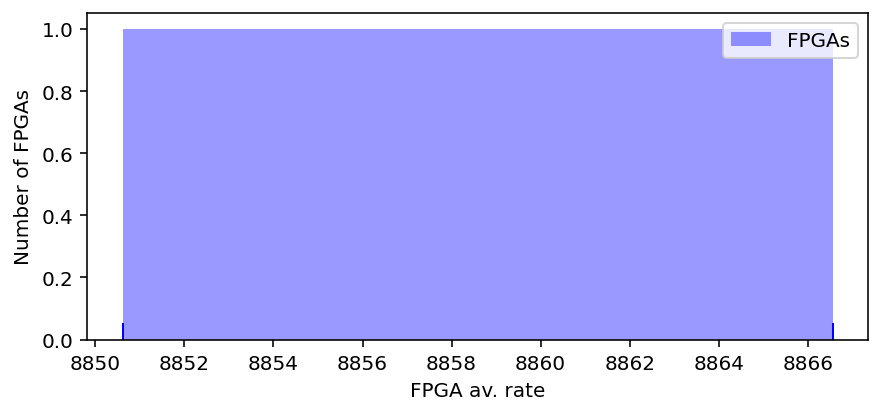

In [35]:
f, ax = plt.subplots(figsize=(7, 3))
sns.distplot(
    fpga_rate_list,
    kde=False,
    label='FPGAs',
    color='b',
    rug=True,
    )
plt.legend()
ax.set(xlabel='FPGA av. rate', ylabel='Number of FPGAs')

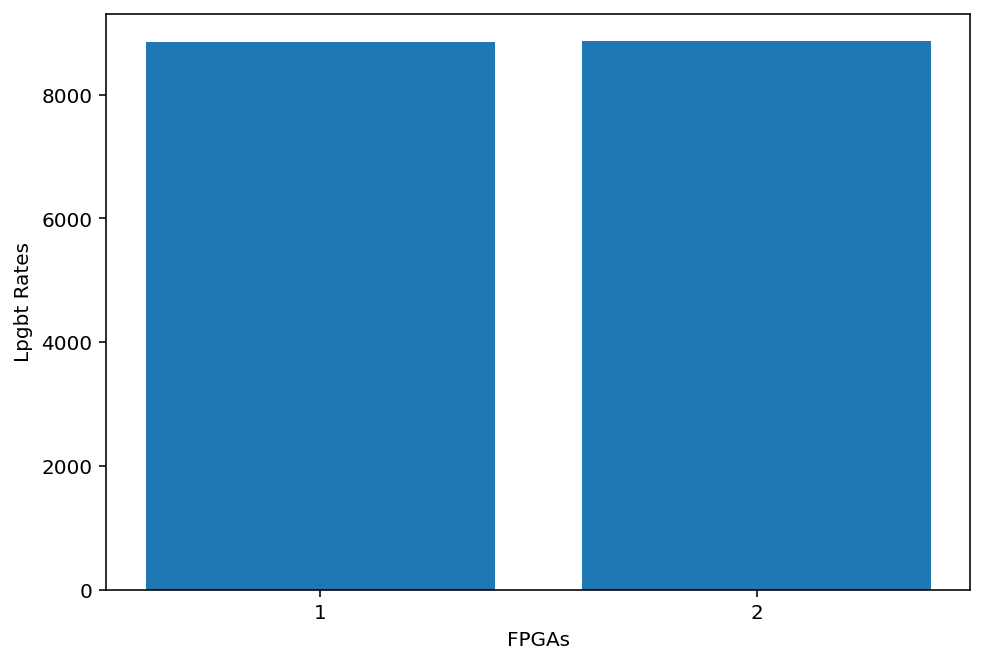

In [36]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
#FPGAs = ["1","2"]  
FPGAs=[str(i) for i in range(1,nFPGA+1)]
Rates = fpga_rate_list
ax.set_ylabel('Lpgbt Rates')
ax.set_xlabel("FPGAs")
ax.bar(FPGAs,Rates)
plt.show()

In [37]:
single_array=[]
for i in Single:
    for j in Slink:
        list=[0]*nSlinks
        if 0.9<=pyo.value(model.GKSingles[i,j])<=1.0000009:
            a=int(j)
            list[a-1]=1           
            single_array.append(list)

In [38]:
list=[]
for i in Single:
    for j in Slink:
        if (pyo.value(model.GKSingles[i,j]))==1:
            list.append(i)
list


['58',
 '382',
 '40',
 '380',
 '570',
 '568',
 '112',
 '474',
 '114',
 '472',
 '506',
 '504',
 '290',
 '292',
 '410',
 '408',
 '219',
 '218',
 '316',
 '201',
 '318',
 '200',
 '36',
 '38',
 '442',
 '440',
 '76',
 '78',
 '346',
 '344',
 '238',
 '236',
 '378',
 '376',
 '264',
 '262',
 '165',
 '164',
 '183',
 '182',
 '1',
 '0',
 '19',
 '18',
 '792',
 '35',
 '34',
 '739',
 '723',
 '722',
 '233',
 '657',
 '658',
 '776',
 '659',
 '656',
 '777',
 '232',
 '753',
 '395',
 '1010',
 '1011',
 '1073',
 '394',
 '1067',
 '615',
 '690',
 '614',
 '1108',
 '633',
 '635',
 '307',
 '331',
 '634',
 '632',
 '702',
 '1093',
 '1043',
 '301',
 '306',
 '300',
 '329',
 '330',
 '328',
 '764',
 '1088',
 '1025',
 '585',
 '1158',
 '1160',
 '1162',
 '1159',
 '1164',
 '1166',
 '1167',
 '1157',
 '1165',
 '1161',
 '1156',
 '1163',
 '1146',
 '1149',
 '1148',
 '1147',
 '1145',
 '1150',
 '1152',
 '1151',
 '1153',
 '1155',
 '1154',
 '1144',
 '1134',
 '1137',
 '1142',
 '1133',
 '1136',
 '1139',
 '1135',
 '1143',
 '1138',
 '11

In [39]:
for i in Single:
    if i not in list:
        print(i)

In [40]:
#model.display()


In [41]:
#single_array

In [42]:
len(single_array)

132

In [43]:
singles=np.array(single_array)
s=[]
for i in singleGBTRates.values():
    s.append(i)
singleGBTRatesMAIN=np.array(s)

In [44]:
hml_single=(singles.T*singleGBTRatesMAIN).T
hml_single[:,0]

array([  0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    , 205.537 ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    , 214.7686,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
        86.0599,   0.    ,   0.    ,   0.    ,   0.    ,   0. 

In [45]:
double_array=[]
for i in Double:
    for j in Slink:
        list=[0]*nSlinks
        if 0.9<=pyo.value(model.GKDoubles[i,j])<=1.00009:#or ==singleGBTRates[i]
            a=int(j)# 1 en 12 ye kadar bir sayı
            list[a-1]=1
            #print(list)
            double_array.append(list)
d=[]
for i in doubleGBTRates.values():
    d.append(i)
doubleGBTRatesMAIN=np.array(d)
doubles=np.array(double_array)
hml_double=(doubles.T*doubleGBTRatesMAIN).T
hml_double

array([[  0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
          0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
          0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
          0.    , 467.5174,   0.    ,   0.    ,   0.    ,   0.    ],
       [  0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
          0.    ,   0.    , 467.6358,   0.    ,   0.    ,   0.    ,
          0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
          0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ],
       [  0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
          0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
          0.    ,   0.    ,   0.    ,   0.    ,   0.    , 483.2248,
          0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ],
       [  0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
          0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
          0.    ,   0.    ,   0.    , 483.269

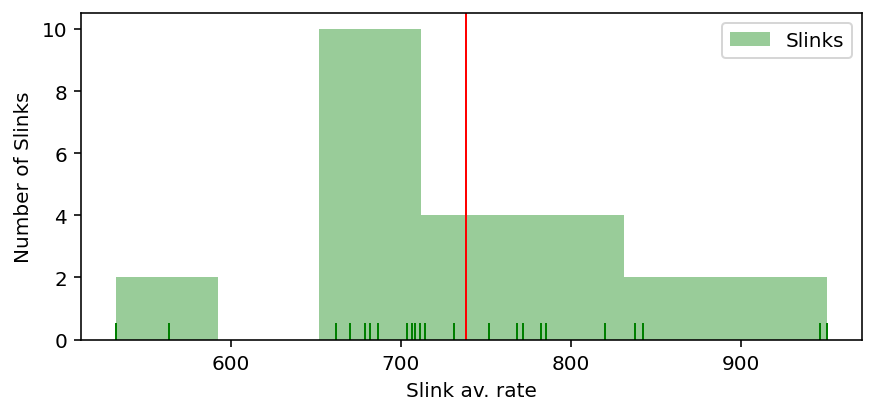

In [46]:
f, ax = plt.subplots(figsize=(7, 3))
sns.distplot(
    slink_rate_list,
    kde=False,
    label='Slinks',
    color='g',
    rug=True,
    )
plt.legend()
ax.set(xlabel='Slink av. rate', ylabel='Number of Slinks')
plt.axvline(linewidth=1, color='r',x=totalRate / nSlinks)

In [47]:
#########  SCATTER PLOTS PART ######


hml_temp_single=[]
for j in range(nSlinks):
    a=[]
    for i in hml_single[:,j]:
        if i !=0:
            a.append(i)
    #b=np.array(a)
    hml_temp_single.append(a)
hml2_single=np.array([hml_temp_single])

hml_temp_double=[]
for j in range(nSlinks):
    a=[]
    for i in hml_double[:,j]:
        if i !=0:
            a.append(i)
    #b=np.array(a)
    hml_temp_double.append(a)
hml2_double=np.array([hml_temp_double])

df_tot=pd.DataFrame({"Slinks":[],"Single Lpgbt Rates":[],"Double Lpgbt Rates":[]})
for i in range(nSlinks):
    c={"Slinks":[str(i)]*len(hml_temp_single[i]),"Single Lpgbt Rates":hml_temp_single[i],"Double Lpgbt Rates":hml_temp_double[i]}
    df2_tot=pd.DataFrame({ key:pd.Series(value) for key, value in c.items() })

    df_tot=pd.concat([df_tot,df2_tot],ignore_index=True)
    #df.append(df2,ignore_index=True)
pd.set_option('display.max_rows', None)

df_double2=pd.DataFrame({"Slinks":[],"Lpgbt Rates":[],"link variable":[]})
for i in range(nSlinks):
    c={"Slinks":[str(i)]*len(hml_temp_double[i]),"Lpgbt Rates":hml_temp_double[i],"link variable":["double"]*len(hml_temp_double[i]),"total rate":slink_rate_list[i]}
    df2_single=pd.DataFrame(c)
    df2_double=pd.DataFrame(c)
    df_double2=pd.concat([df_double2,df2_double],ignore_index=True)
    #df.append(df2,ignore_index=True)
pd.set_option('display.max_rows', None)

df_single2=pd.DataFrame({"Slinks":[],"Lpgbt Rates":[],"link variable":[]})
for i in range(nSlinks):
    c={"Slinks":[str(i)]*len(hml_temp_single[i]),"Lpgbt Rates":hml_temp_single[i],"link variable":["single"]*len(hml_temp_single[i]),"total rate":(slink_rate_list[i])}
    df2_single=pd.DataFrame(c)
    df_single2=pd.concat([df_single2,df2_single],ignore_index=True)
    
df_together=pd.concat([df_single2,df_double2], axis=0)

<ipython-input-47-b0a73b901ab4>:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df2_tot=pd.DataFrame({ key:pd.Series(value) for key, value in c.items() })


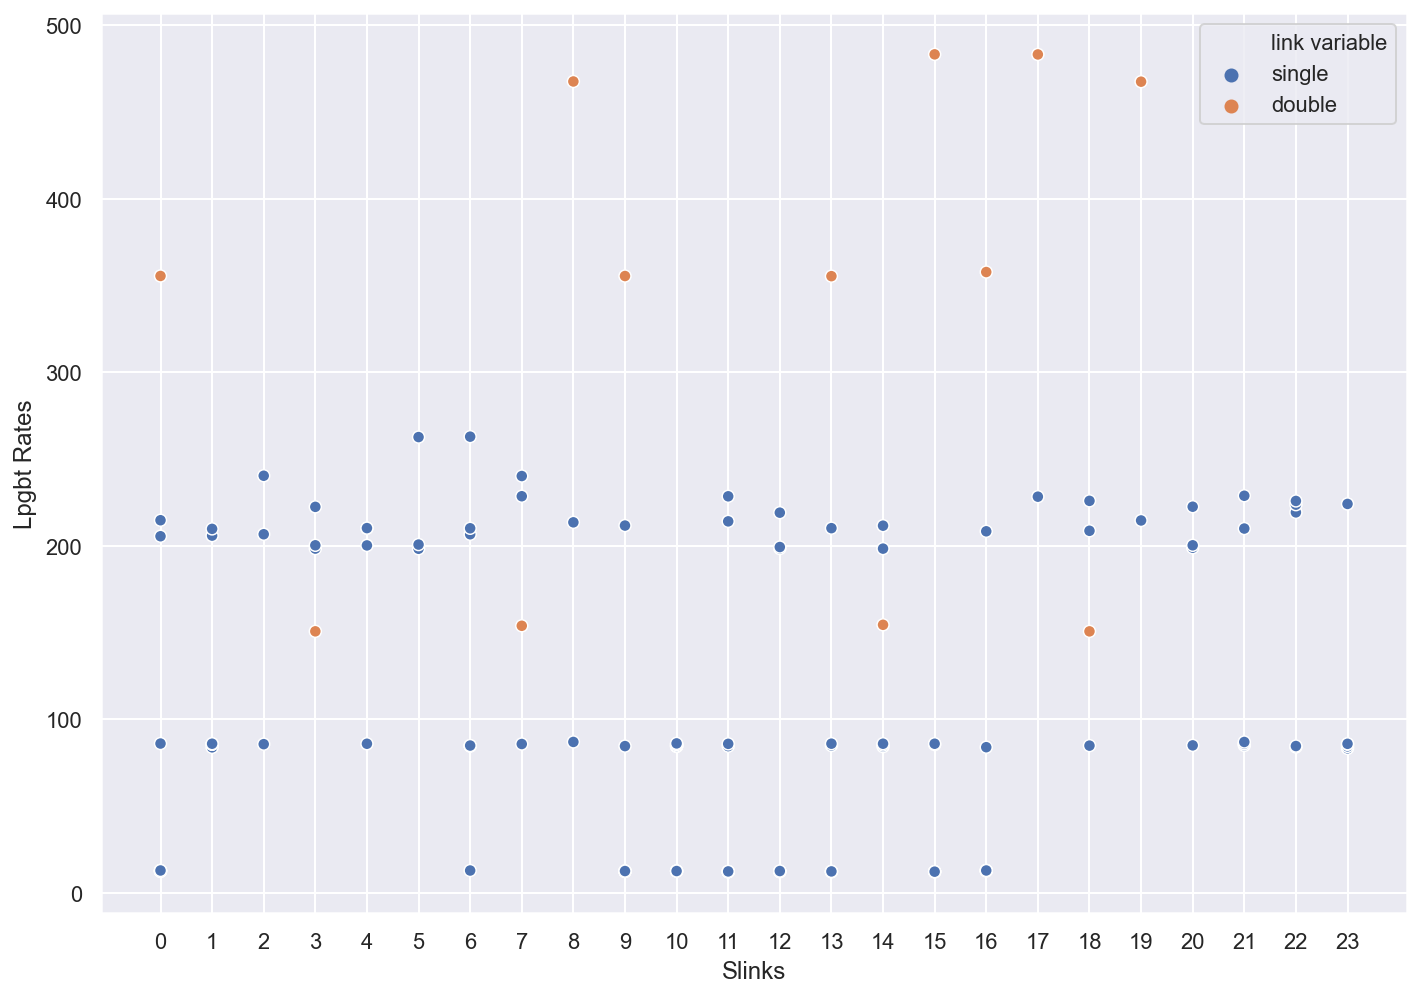

In [59]:
sns.scatterplot(data=df_together, x="Slinks", y="Lpgbt Rates", hue="link variable")
sns.set(rc={'figure.figsize':(11.7,8.27)})

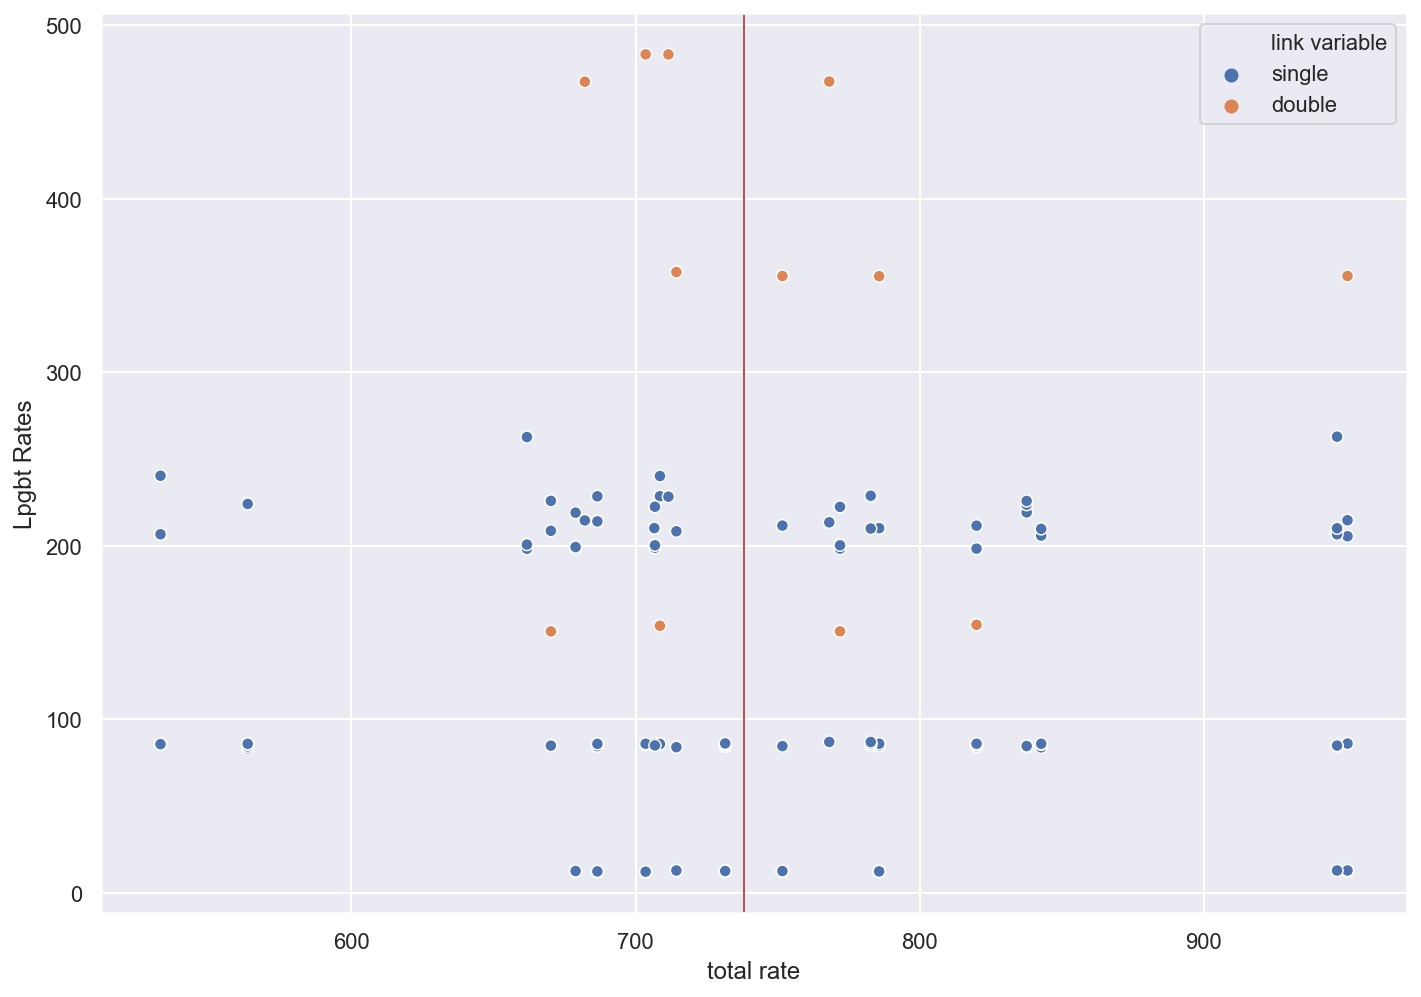

In [49]:
sns.scatterplot(data=df_together, x="total rate", y="Lpgbt Rates", hue="link variable")
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.axvline(linewidth=1, color='r',x=totalRate / nSlinks)

[Text(0, 0.5, 'Number of links'), Text(0.5, 0, 'Av. rate')]

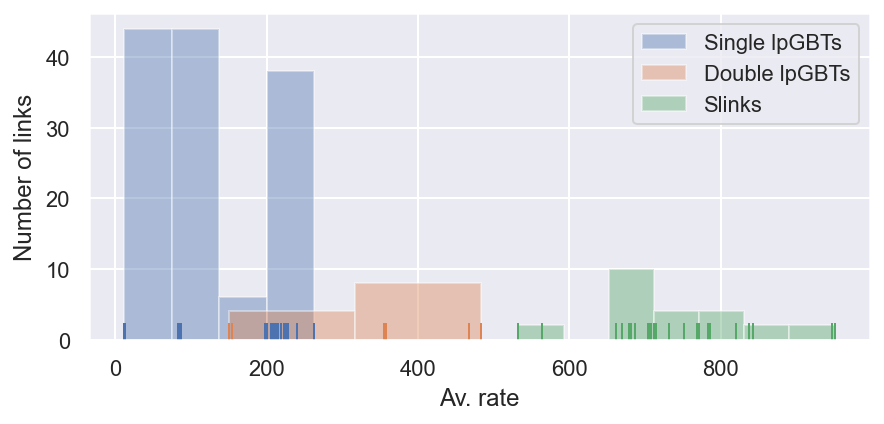

In [50]:
f, ax = plt.subplots(figsize=(7, 3))
sns.distplot(
    singleGBTRatesMAIN,
    kde=False,
    rug=True,
    label='Single lpGBTs'
    )
sns.distplot(
    doubleGBTRatesMAIN,
    kde=False,
    rug=True,
    label='Double lpGBTs'
    )
sns.distplot(
    slink_rate_list,
    kde=False,
    rug=True,
    label='Slinks'
    )
plt.legend()
ax.set(xlabel='Av. rate', ylabel='Number of links')

[Text(0, 0.5, 'Number of links'),
 Text(0.5, 0, 'Av. rate per (average number of) lpGBTs')]

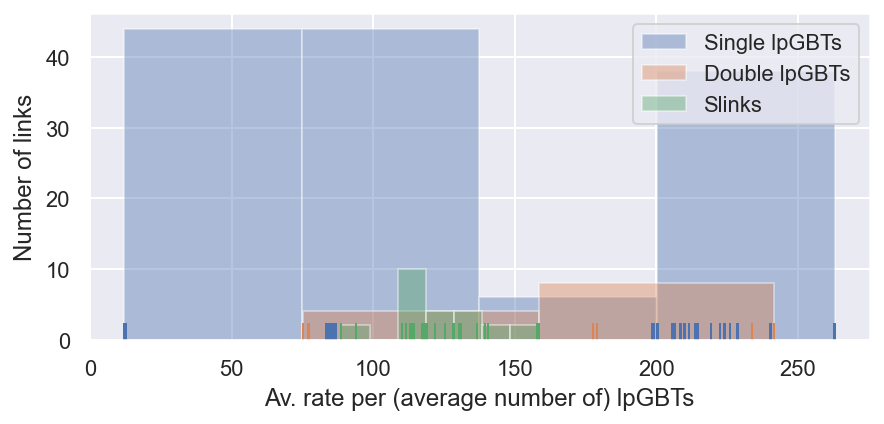

In [51]:
f, ax = plt.subplots(figsize=(7, 3))
sns.distplot(
    singleGBTRatesMAIN,
    kde=False,
    rug=True,
    label='Single lpGBTs'
    )
sns.distplot(
    np.array(doubleGBTRatesMAIN)/2,
    kde=False,
    rug=True,
    label='Double lpGBTs'
    )
sns.distplot(
    np.array(slink_rate_list)/(nGBTs/nSlinks),
    kde=False,
    rug=True,
    label='Slinks'
    )
plt.legend()
ax.set(xlabel='Av. rate per (average number of) lpGBTs', ylabel='Number of links')

[Text(79.0, 0.5, 'lpGBT single'), Text(0.5, 61.0, 'Slink')]

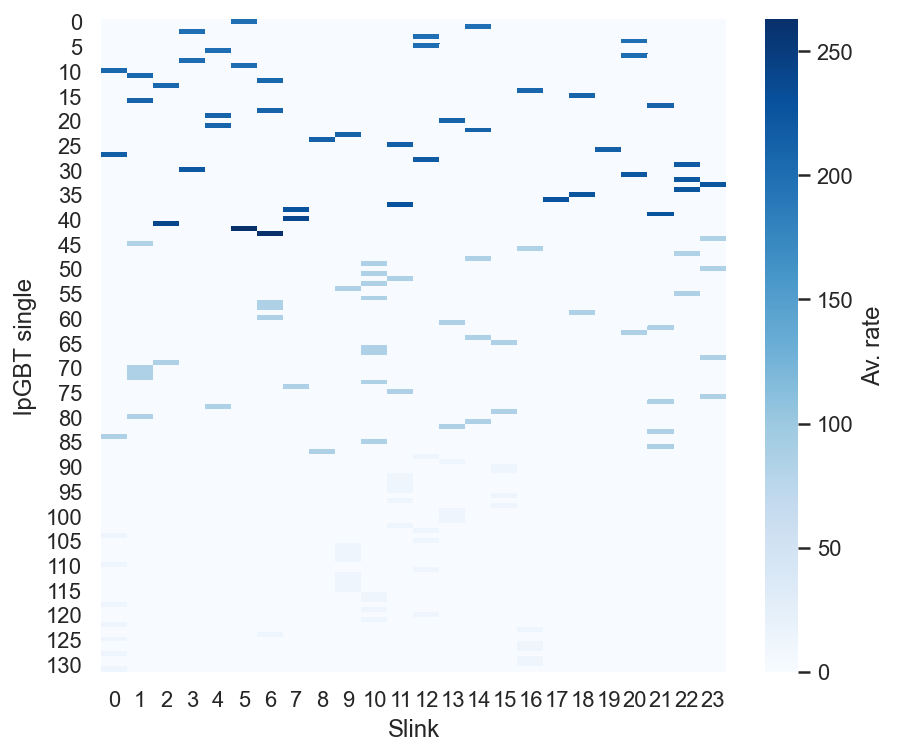

In [52]:
(wd, ht) = (7, 6)
vmax = max(singleGBTRatesMAIN)
f, ax = plt.subplots(figsize=(wd, ht))
sns.heatmap(
    (singles.T * singleGBTRatesMAIN).T,
    cmap='Blues', cbar_kws={'label': 'Av. rate'},
    vmin=0, vmax=vmax
)
ax.set(xlabel='Slink', ylabel='lpGBT single')

[Text(79.0, 0.5, 'lpGBT double'), Text(0.5, -37.18181818181819, 'Slink')]

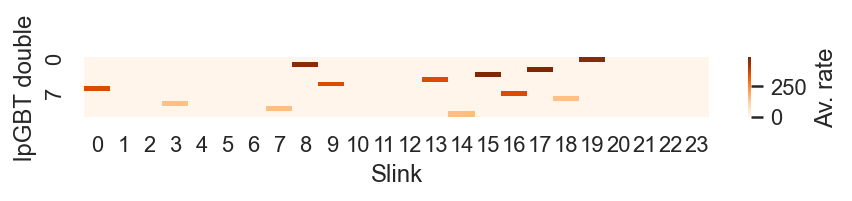

In [53]:
f, ax = plt.subplots(figsize=(wd, ht * (nGBTDoubles/nGBTSingles)))
vmax = max(doubleGBTRatesMAIN)
sns.heatmap(
    ((doubles.T) * doubleGBTRatesMAIN).T,
    cmap='Oranges', cbar_kws={'label': 'Av. rate'},
    vmin=0, vmax=vmax
)
ax.set(xlabel='Slink', ylabel='lpGBT double')

[Text(79.0, 0.5, 'Slink'), Text(0.5, 61.0, 'FPGA')]

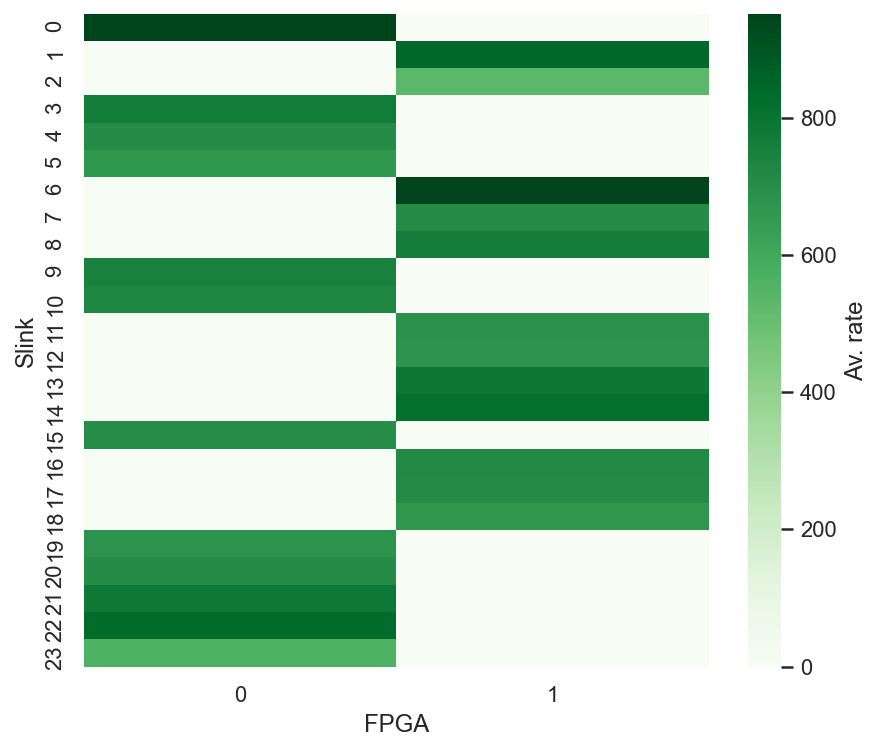

In [54]:
(wd, ht) = (7, 6)

vmax = max(Slinks_Rates)
f, ax = plt.subplots(figsize=(wd, ht))
sns.heatmap(
    (Slinks.T*Slinks_Rates).T,
    cmap='Greens', cbar_kws={'label': 'Av. rate'},
    vmin=0, vmax=vmax
)
ax.set(xlabel='FPGA', ylabel='Slink')

In [55]:
print(singles.sum(axis=0))
print(doubles.sum(axis=0))
print(Slinks.sum(axis=0))
print(singles.sum(axis=0)+doubles.sum(axis=0))

[10  7  3  3  4  3  7  3  2 10 12 10  8  7  5  6  7  1  3  1  4  6  5  5]
[1 0 0 1 0 0 0 1 1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0]
[12 12]
[11  7  3  4  4  3  7  4  3 11 12 10  8  8  6  7  8  2  4  2  4  6  5  5]


In [56]:
singleGBTRatesSMALL=SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== False) ]["EvSize"][:int(nGBTSingles/3)].values
singleGBTRatesMID=SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== False) ]["EvSize"][int(len(SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== False) ])/2)-int(nGBTSingles/6):int(len(SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== False) ])/2)+int(nGBTSingles/6)].values
singleGBTRatesHIGH=SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== False) ]["EvSize"][-1*int(nGBTSingles/3):].values
doubleGBTRatesSMALL=SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== True) ]["EvSize"][:int(nGBTDoubles/3)].values
doubleGBTRatesMID=SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== True) ]["EvSize"][int(len(SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== True) ])/2)-int(nGBTDoubles/6):int(len(SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== True) ])/2)+int(nGBTDoubles/6)].values
doubleGBTRatesHIGH=SizeSortedRates[(SizeSortedRates["doubleDAQlpGBT"]== True) ]["EvSize"][-1*int(nGBTDoubles/3):].values
singleGBTRatesSMALL

array([12.189 , 12.1951, 12.1958, 12.1976, 12.1992, 12.2023, 12.2093,
       12.2107, 12.2131, 12.2151, 12.2246, 12.2254, 12.3632, 12.3748,
       12.3769, 12.3806, 12.3828, 12.3908, 12.3921, 12.3953, 12.3994,
       12.4002, 12.4012, 12.4063, 12.5755, 12.5762, 12.5774, 12.5776,
       12.5809, 12.5811, 12.5839, 12.5873, 12.5907, 12.5923, 12.5927,
       12.6002, 12.8867, 12.8894, 12.8947, 12.8978, 12.9001, 12.9046,
       12.9048, 12.9065])

In [57]:
def create_dataframe():
    hml_double=(doubles.T*doubleGBTRatesMAIN).T
    hml_single=(singles.T * singleGBTRatesMAIN).T
    a=[]
    for j in range(nSlinks):
        sum_low=0
        sum_mid=0
        sum_high=0
        sum_doub_low=0
        sum_doub_mid=0
        sum_doub_high=0
        list=[]
        for i in hml_single[:,j]:
            if i in singleGBTRatesSMALL:
                sum_low+=1
        list.append(sum_low)
        for i in hml_single[:,j]:
            if i in singleGBTRatesMID:
                sum_mid+=1
        list.append(sum_mid)
        for i in hml_single[:,j]:
            if i in singleGBTRatesHIGH:
                sum_high+=1
        list.append(sum_high)
        for i in hml_double[:,j]:
            if i in doubleGBTRatesSMALL:
                sum_doub_low+=1
        list.append(sum_doub_low)
        for i in hml_double[:,j]:
            if i in doubleGBTRatesMID:
                sum_doub_mid+=1
        list.append(sum_doub_mid)
        for i in hml_double[:,j]:
            if i in doubleGBTRatesHIGH:
                sum_doub_high+=1
        list.append(sum_doub_high)

        a.append(list)
    b=np.array(a)
    c=b.T
    tablo=pd.DataFrame(c,index=["Single Low","Single Mid","Single High","Double Low","Double Mid","Double High"],
                          columns=["Slink"+str(i+1) for i in range(nSlinks)])
    tablo.index.name="lpgbt Rates"

    return tablo

In [58]:
create_dataframe().to_csv("./SlinkLinks.csv")
create_dataframe()

,Slink1,Slink2,Slink3,Slink4,Slink5,Slink6,Slink7,Slink8,Slink9,Slink10,...,Slink15,Slink16,Slink17,Slink18,Slink19,Slink20,Slink21,Slink22,Slink23,Slink24
lpgbt Rates,,,,,,,,,,,,,,,,,,,,,
Single Low,7,0,0,0,0,0,1,0,0,8,...,0,4,5,0,0,0,0,0,0,0
Single Mid,1,5,1,0,1,0,3,1,1,1,...,3,2,1,0,1,0,1,4,2,4
Single High,2,2,2,3,3,3,3,2,1,1,...,2,0,1,1,2,1,3,2,3,1
Double Low,0,0,0,1,0,0,0,1,0,0,...,1,0,0,0,1,0,0,0,0,0
Double Mid,1,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
Double High,0,0,0,0,0,0,0,0,1,0,...,0,1,0,1,0,1,0,0,0,0


## Taking `GEKKO` for a spin

More information at:
- https://gekko.readthedocs.io/en/latest/examples.html#mixed-integer-nonlinear-programming
- https://apmonitor.com/wiki/index.php/Main/GekkoPythonOptimization

In [ ]:
import gekko
print(gekko.__version__)

In [ ]:
from gekko import GEKKO

In [ ]:
m = GEKKO() # Initialize gekko
m.options.SOLVER=1  # APOPT is an MINLP solver

m.options.MAX_MEMORY=6

# optional solver settings with APOPT
# More details at https://apmonitor.com/wiki/index.php/Main/OptionApmSolver
m.solver_options = ['minlp_maximum_iterations 10000', \
                    # minlp iterations with integer solution
                    'minlp_max_iter_with_int_sol 10000', \
                    # treat minlp as nlp
                    'minlp_as_nlp 0', \
                    # nlp sub-problem max iterations
                    'nlp_maximum_iterations 10', \
                    # 1 = depth first, 2 = breadth first
                    'minlp_branch_method 1', \
                    # maximum deviation from whole number
                    'minlp_integer_tol 0.05', \
                    # covergence tolerance
                    'minlp_gap_tol 0.01',
                    #'minlp_print_level 10',
                    ]

In [ ]:
nGBTSingles=len(singleGBTRates.keys())
nGBTDoubles=len(doubleGBTRates.keys())
singleGBTRates=[i for i in singleGBTRates.values()]
doubleGBTRates=[i for i in doubleGBTRates.values()]

We need two assignment matrices: one for single lpGBTs and one for double lpGBTs.

Each matrix is "boolean" in the sense that it tells if a single/double lpGBT (rows) is connected to a given Slink (columns).
This is represented by the elements having to be either 0 or 1, i.e. integers with lower bound = 0 and upper bound = 1.

In [ ]:
import numpy as np
GKSingles = m.Array(
    m.Var, (nGBTSingles, nSlinks),
    value=np.random.choice([0, 1], p=[1-1/nSlinks, 1/nSlinks]), lb=0, ub=1, integer=True
)

GKDoubles = m.Array(
    m.Var, (nGBTDoubles, nSlinks),
    value=np.random.choice([0, 1], p=[1-1/nSlinks, 1/nSlinks]), lb=0, ub=1, integer=True
)

GKSlinks = m.Array(
    m.Var, (nSlinks, nFPGA),
    value=np.random.choice([0, 1], p=[1-1/nFPGA, 1/nFPGA]), lb=0, ub=1, integer=True
)

#print(GKSlinks)

The fact that each lpGBT single or double can only be connected to only one Slink is introduced for each of the rows in the matrices for singles and doubles.

In [ ]:
for i in range(nGBTSingles):
    m.Equation( sum([ GKSingles[i, j] for j in range(nSlinks) ]) == 1 )

for i in range(nGBTDoubles):
    m.Equation( sum([ GKDoubles[i, j] for j in range(nSlinks) ]) == 1 )

# Each Slink is connected to one FPGA    
for i in range(nSlinks):
    m.Equation( sum([ GKSlinks[i, j] for j in range(nFPGA) ]) == 1 )    

Another constraint in the problem is the maximum number of lpGBTs that can be connected to a given Slink.
Since double lpGBTs represent two links, they have a weight of 2 in the sum over all inputs.

In [ ]:
for j in range(nSlinks):
    m.Equation(
            sum([ GKSingles[i, j] for i in range(nGBTSingles) ])
        + 2*sum([ GKDoubles[i, j] for i in range(nGBTDoubles) ])
        <= maxGBTsPerSlink
    )

for j in range(nFPGA):    
    m.Equation(
        sum([ GKSlinks[i, j] for i in range(nSlinks) ]) == SlinkPerFPGA 
    )

Computer the rate of each Slink, summing over the lpGBT singles and doubles connected to it

In [ ]:
GKslinkRates = [
    m.Intermediate(
          sum([ singleGBTRates[i]*GKSingles[i, j] for i in range(nGBTSingles) ])
        + sum([ doubleGBTRates[i]*GKDoubles[i, j] for i in range(nGBTDoubles) ]),
        name=f'outRate_{j}'
    )
    for j in range(nSlinks)
]

Limiting Slink rates

In [ ]:
for j in range(nSlinks):    
    m.Equation(
       sum([ singleGBTRates[i]*GKSingles[i, j] for i in range(nGBTSingles) ]) + sum([ doubleGBTRates[i]*GKDoubles[i, j] for i in range(nGBTDoubles) ]) <= maxSlinkRateGekko
    )    

Create the objective function from the variance of the Slink rates:

variance = 0 <=> all links have the same rate

Using something like the maximum of the Slink rates would make the problem non-differentiable. That said, it could be tried since [GEKKO has some support for "logical functions"](https://gekko.readthedocs.io/en/latest/model_methods.html#logical-functions).

In [ ]:
print('Average SlinkRate: ',( sum(singleGBTRates)+sum(doubleGBTRates) ) / nSlinks)

In [ ]:
GKavSlinkRate = m.Const(
    ( sum(singleGBTRates)+sum(doubleGBTRates) ) / nSlinks
)

GKslinkRatesVariance = m.Intermediate(
    sum( (slinkRate-GKavSlinkRate)**2 for slinkRate in GKslinkRates) / (nSlinks-1)
)

GKslinkRatesStDev = m.Intermediate( m.sqrt(GKslinkRatesVariance) )

m.Obj(GKslinkRatesStDev)

In [ ]:
#m.solve(disp=False)

In [ ]:
print(f"""
Solution found with
 - Average rate of Slinks = {GKavSlinkRate.value}
 - StdDev of Slinks rates = {GKslinkRatesStDev.value[0]}
""")
for j in range(nSlinks):  
    #print(GKslinkRates)
    print(GKslinkRates[j].value[0])

In [ ]:
def deGekkoify(gekkoExpression):
    return gekkoExpression[0]

Singles = np.vectorize(deGekkoify)(GKSingles)
Doubles = np.vectorize(deGekkoify)(GKDoubles)
Slinks = np.vectorize(deGekkoify)(GKSlinks)

slinkRates = [v.value[0] for v in GKslinkRates]

In [ ]:
f, ax = plt.subplots(figsize=(7, 3))
sns.distplot(
    slinkRates,
    kde=False,
    label='Slinks',
    color='g',
    rug=True,
    )
plt.legend()
ax.set(xlabel='Slink av. rate', ylabel='Number of Slinks')

In [ ]:
f, ax = plt.subplots(figsize=(7, 3))
sns.distplot(
    singleGBTRates,
    kde=False,
    rug=True,
    label='Single lpGBTs'
    )
sns.distplot(
    doubleGBTRates,
    kde=False,
    rug=True,
    label='Double lpGBTs'
    )
sns.distplot(
    slinkRates,
    kde=False,
    rug=True,
    label='Slinks'
    )
plt.legend()
ax.set(xlabel='Av. rate', ylabel='Number of links')

In [ ]:
f, ax = plt.subplots(figsize=(7, 3))
sns.distplot(
    singleGBTRates,
    kde=False,
    rug=True,
    label='Single lpGBTs'
    )
sns.distplot(
    np.array(doubleGBTRates)/2,
    kde=False,
    rug=True,
    label='Double lpGBTs'
    )
sns.distplot(
    np.array(slinkRates)/(nGBTs/nSlinks),
    kde=False,
    rug=True,
    label='Slinks'
    )
plt.legend()
ax.set(xlabel='Av. rate per (average number of) lpGBTs', ylabel='Number of links')

In [ ]:
(wd, ht) = (7, 6)
vmax = max(singleGBTRates)
f, ax = plt.subplots(figsize=(wd, ht))
sns.heatmap(
    (Singles.T * singleGBTRates).T,
    cmap='Blues', cbar_kws={'label': 'Av. rate'},
    vmin=0, vmax=vmax
)
ax.set(xlabel='Slink', ylabel='lpGBT single')

In [ ]:
f, ax = plt.subplots(figsize=(wd, ht * (nGBTDoubles/nGBTSingles)))
vmax = max(doubleGBTRates)
sns.heatmap(
    ((Doubles.T) * doubleGBTRates).T,
    cmap='Oranges', cbar_kws={'label': 'Av. rate'},
    vmin=0, vmax=vmax
)
ax.set(xlabel='Slink', ylabel='lpGBT double')

In [ ]:
(wd, ht) = (7, 6)
SlinkRates = [GKslinkRates[j].value[0] for j in range(nSlinks)]
vmax = max(SlinkRates)
f, ax = plt.subplots(figsize=(wd, ht))
sns.heatmap(
    (Slinks.T * SlinkRates).T,
    cmap='Greens', cbar_kws={'label': 'Av. rate'},
    vmin=0, vmax=vmax
)
ax.set(xlabel='FPGA', ylabel='Slink')

In [ ]:
print(Singles.sum(axis=0))
print(Doubles.sum(axis=0))
print(Slinks.sum(axis=0))
print(Singles.sum(axis=0)+Doubles.sum(axis=0))

In [ ]:
def Create_dataframe():
    hml_double=(Doubles.T*doubleGBTRatesMAIN).T
    hml_single=(Singles.T * singleGBTRatesMAIN).T
    a=[]
    for j in range(nSlinks):
        sum_low=0
        sum_mid=0
        sum_high=0
        sum_doub_low=0
        sum_doub_mid=0
        sum_doub_high=0
        list=[]
        for i in hml_single[:,j]:
            if i in singleGBTRatesSMALL:
                sum_low+=1
            elif i in singleGBTRatesMID:
                sum_mid+=1
            elif i in singleGBTRatesHIGH:
                sum_high+=1
        list.append(sum_low)
        list.append(sum_mid)
        list.append(sum_high)
        for i in hml_double[:,j]:
            if i in doubleGBTRatesSMALL:
                sum_doub_low+=1
            elif i in doubleGBTRatesMID:
                sum_doub_mid+=1
            elif i in doubleGBTRatesHIGH:
                sum_doub_high+=1
        list.append(sum_doub_low)
        list.append(sum_doub_mid)
        list.append(sum_doub_high)
        a.append(list)
    b=np.array(a)
    c=b.T
    tablo=pd.DataFrame(c,index=["Single Low","Single Mid","Single High","Double Low","Double Mid","Double High"],
                          columns=["Slink1","Slink2","Slink3","Slink4","Slink5","Slink6","Slink7","Slink8","Slink9","Slink10","Slink11","Slink12"])
    tablo.index.name="lpgbt Rates"

    return tablo

In [ ]:
Create_dataframe()